# Facial recognition convolutional neural network, multi class and multi label

In [1]:
import tensorflow.compat.v1 as tf
from tensorflow.keras import datasets, layers, models, optimizers
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

import numpy as np #  provides a multidimensional array object
import matplotlib.pyplot as plt # library for visualizations, graphs
import matplotlib.image as mping # used to read image paths
import tensorflow as tf # machine learning framework
import matplotlib.pyplot as plt # graph plotting library
import pandas as pd # data manipluation
import cv2 # computer vision library
from sklearn.metrics import confusion_matrix # plotting tool for confususion matrix
import skimage.io as io # read write images in various formats
import itertools # Functions creating iterators for efficient looping
import random # used to generate random numbers
from PIL import Image # python image libary
import os # OS manipuilation 
from matplotlib import pyplot
from sklearn.model_selection import train_test_split # used to split the dataset into training and testing data
# importing modules from tensorflow.keras to keep code readable
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Activation,MaxPool2D,GlobalMaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from imgaug import augmenters as iaa # image augmentation library
import seaborn as sns
%matplotlib inline
sns.set()

import ntpath

In [2]:
print("Tensorflow version:",tf.__version__) # check tensorflow version

Tensorflow version: 2.2.0


### Variables

In [3]:
root = "/home/jj/Desktop/MSc_Data_Science/Semester_2/COMP_1804_Applied_ML/Coursework/Coursework_Upload_Files/Official_first_500/" # parent folder to save all data
image_data = 'Combined_500_Images'
video_data = 'Official_first_500'

In [4]:
dataset_dict = {
    'wrinkles_id':{
        0: 'does not have',
        1: 'has'
    },
    'freckles_id' :{
        0: 'does not have',
        1: 'has'
    },
    'glasses_id' :{
        0: 'does not have',
        1: 'wear normal',
        2: 'wear sunglasses'
    },
    'hair_colour_id' :{
        0: 'brown',
        1: 'black',
        2: 'grey',
        3: 'blonde',
        4: 'red',
        5: 'white',
        6: 'mixed',
        7: 'other',
        8: 'not visible'
    },
    'hair_top_id':{
        0: 'bald or shaved',
        1: 'has few hair',
        2: 'has thick hair',
        3: 'not visible'
    },
    'human_id':{
        0: 'human',
        1: 'Not Human'
    }
}

### Hyperperameters

In [5]:
MODEL_NAME = "" # name of model
USE_DATA_GENERATOR = False # bool used to switch between using data generator during training
BATCH_SIZE = 32 # batch size to pass while training
EPOCS = 10 # number of epochs to run
ACTIVATION_LAYER = "relu"  # activation function
ACTIVATION_OUTPUT = "softmax" # output activation function
OPTIMIZER = SGD(lr=0.0001) # optimiser
LOSS = "categorical_crossentropy" # loss function

### Directory checking or creation

In [6]:
# Model data files
if not os.path.exists('%s/Model_Data/%s' %(root, MODEL_NAME)):
    os.makedirs('%s/Model_Data/%s' %(root, MODEL_NAME))
    print("***\nNew model directory created\n***")
else:
    print("***\nModel directory already present\n***")
    
# dataset files
#if not os.path.exists('%s/dataset'%(PATH)):
#    os.makedirs('%s/dataset'%(PATH))
#    print("***\nNew dataset directory created\n***")
#else:
#    print("***\nDataset directory already present\n***")

***
Model directory already present
***


In [7]:
#CATEGORIES = ["image_name", "wrinkles", "freakles", "glasses",  "hair_color", "hair_top", "not_human"]

# reading the csv file that has been generated
data = pd.read_csv(os.path.join(root,'dataset_1_JJ.csv'))#, names = CATEGORIES)  # joins the data together
# displays the output on a single line
pd.set_option('display.max_colwidth', None)
# read the first 5 lines to test the current code is working
data.head()

image_name  \
0  /home/jj/Desktop/MScDataScience(2020)/Semester2/COMP1804AppliedML/Coursework/4th500imgdataset/183797.jpg   
1  /home/jj/Desktop/MScDataScience(2020)/Semester2/COMP1804AppliedML/Coursework/4th500imgdataset/183823.jpg   
2  /home/jj/Desktop/MScDataScience(2020)/Semester2/COMP1804AppliedML/Coursework/4th500imgdataset/183824.jpg   
3  /home/jj/Desktop/MScDataScience(2020)/Semester2/COMP1804AppliedML/Coursework/4th500imgdataset/183858.jpg   
4  /home/jj/Desktop/MScDataScience(2020)/Semester2/COMP1804AppliedML/Coursework/4th500imgdataset/183889.jpg   

   wrinkles  freakles  glasses  hair_color  hair_top  not_human  
0         0         0        0           0         2          0  
1         0         0        0           0         0          1  
2         0         0        0           0         0          1  
3         0         0        0           0         0          1  
4         0         0        0           0         0          1

In [8]:
# function that takes in the path arguement and splits the path
def path_leaf(path):
  head, tail = ntpath.split(path) # splits the path
  return tail # returns the tail end of the split path

# data frame serise type, invoking the function path_leaf
data['image_name'] = data['image_name'].apply(path_leaf) # this takes the entire data frame and returns only the tail end of the path
#outputs the data
data.head()

image_name  wrinkles  freakles  glasses  hair_color  hair_top  not_human
0  183797.jpg         0         0        0           0         2          0
1  183823.jpg         0         0        0           0         0          1
2  183824.jpg         0         0        0           0         0          1
3  183858.jpg         0         0        0           0         0          1
4  183889.jpg         0         0        0           0         0          1

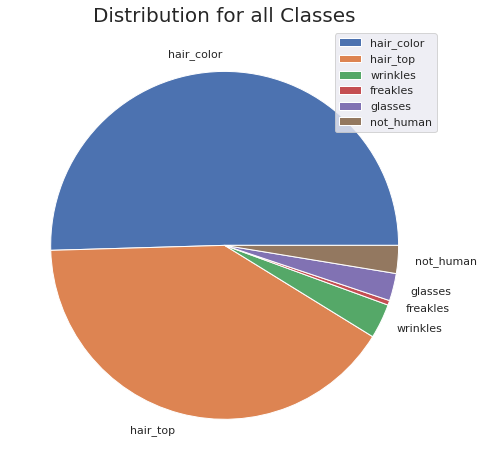

In [72]:
select_all = ['hair_color','hair_top','wrinkles',	'freakles',	'glasses',			'not_human']
plt.figure(figsize=(8, 8))
plt.pie(data[select_all].sum(), labels=data[select_all].columns)
plt.title('Distribution for all Classes', fontsize=20)
plt.legend(loc=1)
plt.show()

In [10]:
# function takes numpy array and checks unique element count, returns array
def count_freq(numpy_data):
    (unique, counts) = np.unique(numpy_data, return_counts=True)
    frequencies = np.asarray((unique, counts)).T   # hold the frequency of each value
    return frequencies  

In [11]:
print(count_freq(data['hair_color']))

[[  0 193]
 [  1 138]
 [  2  21]
 [  3  52]
 [  4  10]
 [  6   2]
 [  7   2]
 [  8  81]]


In [12]:
# function takes in numpy array and string, output bar graphs showing 
# distribution of training and testing data
def plot_freq(frequency, title, labels):
    #labels = frequency[:,0] # labels for x axis
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1]) # axes is absolute coordinates on plot
    
    ax.bar(frequency[0:10, 0],frequency[0:10, 1]) # x and y axis for plot
    plt.xticks(frequency[0:10, 0], labels=labels, rotation = 45) # define the x labels
    plt.title(title) # title
    plt.xlabel("Hair Colour") # x axis label
    plt.ylabel("Number of images")# y axis label
    # loop to get frequency data and display on chart
    for index,data in enumerate(frequency[0:10, 1]):
        # position the text data 
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10),ha="center")
    #if not os.path.exists("%s/Images/%s.png"% (PATH,title)):
    #    plt.savefig("%s/Images/%s.png"% (PATH,title),bbox_inches='tight')

In [13]:
#plot_freq(count_freq(data['hair_color']), "Distribution of Hair Colour", dataset_dict['hair_colour_id'])

In [14]:
import plotly.graph_objects as go
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [15]:
plot_distribution(data['glasses'])

In [16]:
plot_distribution(data['freakles'])

In [17]:
plot_distribution(data['hair_color'])

In [18]:
plot_distribution(data['hair_top'])

In [19]:
plot_distribution(data['not_human'])

In [20]:
"""
Loads images from disk to numpy array
"""
def load_images(datadir, dataframe):
    image_path = []
    image_annotation = []
    # loops through length of updated data
    for i in range(len(data)): # loop though the lenght of the data
        indexed_data = data.iloc[i]
        image_name = indexed_data[0]
        image_path.append(os.path.join(datadir,image_name.strip()))
        
        image_annotation.append([indexed_data[1],indexed_data[2],indexed_data[3],indexed_data[4],indexed_data[5]])
      
        
        
    image_paths = np.asarray(image_path)
    image_annotations = np.asarray(image_annotation)
    return image_paths, image_annotations


In [21]:
image_paths, image_annotations = load_images(root+image_data , data)

In [22]:
# splits the dataset into training data and training data
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, image_annotations, test_size = 0.2, random_state = 6) # data is split with 80% training and 20% validaiotn data
print('Training samples: {} \nValidation Samples: {}'.format(len(X_train), len(X_valid)))

Training samples: 399 
Validation Samples: 100


In [23]:
#function for pre processing
def img_preprocess(img):
  # img = mping.imread(img) # reads the path of the img and stores it in a variable
  
  #img = img[:, :, :3] # change any rgba images to rgb
  img = cv2.GaussianBlur(img, (3,3), 0 ) # smooths image out and reduces the noise of the image
  # above the arguments are the image, the size of the kernal and the deviation of the kernal
  img = cv2.resize(img, (200,200)) # resize the image to reduce the computational power needed
  if img.shape == (200,200):
      img = cv2.cvtColor(np.float32(img), cv2.COLOR_GRAY2RGB) # converts the image to YUV color spacing
        
  # image as first argument tuple as second that the image will be resized too
  img = img/255 # nomalisation of the image
  return img # returns pre processed image

Text(0.5, 1.0, 'Preprocessed Image')

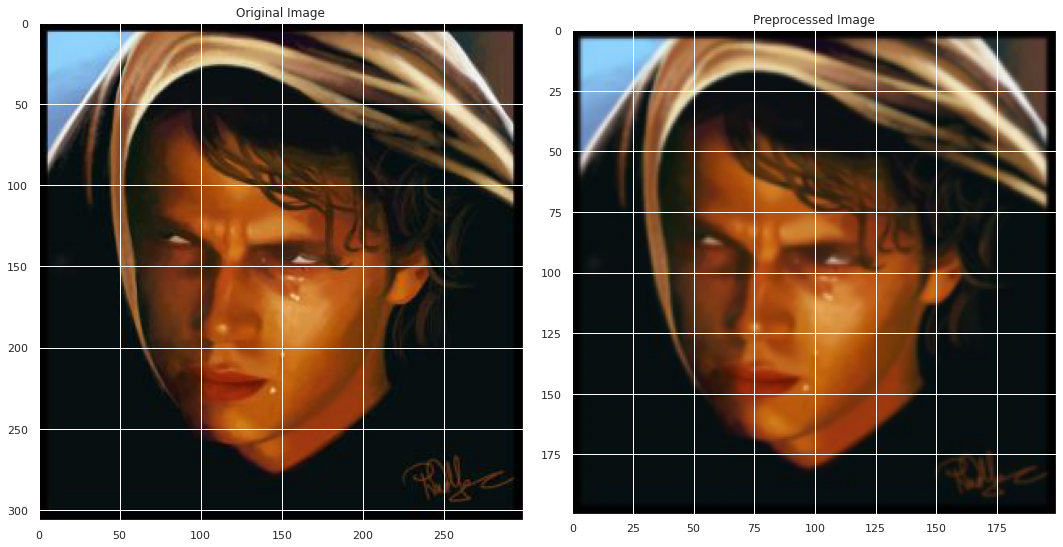

In [24]:
image = image_paths[0] # selects an image that is currently set to index 100
original_image = mping.imread(image) # stores original image that has been read into this variable
preprocessed_image = img_preprocess(original_image) # same image that has been preprocessed using the defined function

fig, axes = plt.subplots(1, 2, figsize=(15,10)) # defines a sub plot to show the original and preprocessed images
fig.tight_layout() # formatting the images
axes[0].imshow(original_image) # show the original image
axes[0].set_title('Original Image') # title of the original image
axes[1].imshow(preprocessed_image) # preprocessed image
axes[1].set_title('Preprocessed Image') # title of the original image

In [25]:
# flipping augmentation
def img_random_flip(image): 
  image = cv2.flip(image, 1) # horizontal flip
  return image # returns the image and steering angle

In [26]:
# image augmentation
def zoom(image):
  zoom = iaa.Affine(scale = (1, 1.4)) # zoom function set to between 1x and 1.4x zoom
  image = zoom.augment_image(image) # augments the zoom of image
  return image

In [27]:
# augmention for bightness
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.6)) # multiplys all pixels by a value
  image = brightness.augment_image(image) # augments the brightness of the image
  return image # returns an augmented image

In [28]:
# image panning
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y':(0.1,0.1)}) # panning 10% left or right and 10% up or down
  image = pan.augment_image(image) # augments the image with pan function
  return image # returns an augmented image

In [29]:
# randomise the occurance of the augmentations
def random_augment(image,annotation):
  image = mping.imread(image)
  if np.random.rand() < 0.5: # 50% of images will be augmented
    image = pan(image)
  if np.random.rand() < 0.5: # 50% of images will be augmented
    #pass
    #print("Zoom")
    image = zoom(image)
  if np.random.rand() < 0.5: # 50% of images will be augmented
    #pass
    #print("Brightness")
    image = img_random_brightness(image)
  if np.random.rand() < 0.5: # 50% of images will be augmented
   #pass
    #print("Flip")
    image = img_random_flip(image)
  return image,annotation

In [30]:
#function for batch agumentation
def batch_generator(image_paths, annotations, batch_size, istraining):
  while True:
    batch_img = [] # stores image in list
    batch_annotations = [] # stores the annotation in a list 
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) -1 ) # randomly selects image
      
      # if statement to test between training images and validation images
      if istraining:
        # training data
        person = data.iloc[random_index]
        wrinkle = person["wrinkles"]
        freakle = person["freakles"]
        glass = person["glasses"]
        hair_color = person["hair_color"]
        hair_top = person["hair_top"]
        
        img,annotation= random_augment(image_paths[random_index],annotation = annotations[random_index]) # stores the randomly selected images and annotation in variables
        
        wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
        freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
        glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
        hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
        hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))
        
      else:
        # validaiton data
        img = mping.imread(image_paths[random_index])
        person = data.iloc[random_index]
        wrinkle = person["wrinkles"]
        freakle = person["freakles"]
        glass = person["glasses"]
        hair_color = person["hair_color"]
        hair_top = person["hair_top"]
        annotation = annotations[random_index]
        wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
        freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
        glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
        hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
        hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))
        
      img = img_preprocess(img) # call to function
      batch_img.append(img) # appends the image to list
      batch_annotations.append(annotation) # appends the annotation angle to list
      
    yield (np.asarray(batch_img), [np.array(wrinkles), np.array(freakles), np.array(glasses), np.array(hair_colors), np.array(hair_tops)]) # using yield to suspend the function
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]

In [31]:
print(data.head())

   image_name  wrinkles  freakles  glasses  hair_color  hair_top  not_human
0  183797.jpg         0         0        0           0         2          0
1  183823.jpg         0         0        0           0         0          1
2  183824.jpg         0         0        0           0         0          1
3  183858.jpg         0         0        0           0         0          1
4  183889.jpg         0         0        0           0         0          1


Text(0.5, 1.0, 'Validaiton Image')

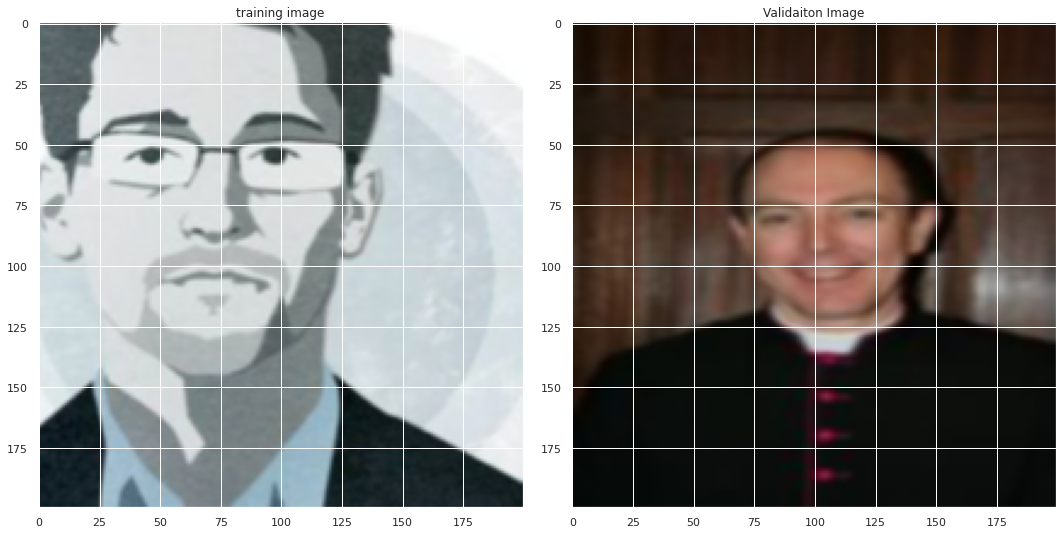

In [32]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15,10)) # plot to display the images
fig.tight_layout() # tidy up the plot

axs[0].imshow(x_train_gen[0]) # original image
axs[0].set_title('training image') # title of the original image

axs[1].imshow(x_valid_gen[0]) # displays the brightness augmented image
axs[1].set_title('Validaiton Image') # titles the augmented image

In [33]:
def make_default_conv_layers(inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x

In [34]:
"""
    This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
    followed by the Dense output layer.
"""
def build_wrinkles_branch(inputs, num_wrinkles = 2):
    x = make_default_conv_layers(inputs)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_wrinkles)(x)
    x = Activation("sigmoid", name="wrinkles_output")(x)

In [35]:
"""
    Function to call convolutional layer when needed
"""
def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

In [36]:
input_layer = Input(shape=(200, 200, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)


In [37]:
 # for wrinkles prediction
_ = Dense(units=128, activation='relu')(bottleneck)
wrinkles_output = Dense(units=2, activation='softmax', name='wrinkles_output')(_)

In [38]:
# for freakles prediction
_ = Dense(units=128, activation='relu')(bottleneck)
freakles_output = Dense(units=2, activation='softmax', name='freakles_output')(_)

In [39]:
# for glasses prediction
_ = Dense(units=128, activation='relu')(bottleneck)
glasses_output = Dense(units=3, activation='softmax', name='glasses_output')(_)

In [40]:
# for hair colour prediction
_ = Dense(units=128, activation='relu')(bottleneck)
hair_colour_output = Dense(units=9, activation='softmax', name='hair_colour_output')(_)

In [41]:
# for hair top prediction
_ = Dense(units=128, activation='relu')(bottleneck)
hair_top_output = Dense(units=4, activation='softmax', name='hair_top_output')(_)

In [42]:
model = Model(inputs=input_layer, outputs=[wrinkles_output, freakles_output, glasses_output,hair_colour_output,hair_top_output])

In [43]:
data.head()

image_name  wrinkles  freakles  glasses  hair_color  hair_top  not_human
0  183797.jpg         0         0        0           0         2          0
1  183823.jpg         0         0        0           0         0          1
2  183824.jpg         0         0        0           0         0          1
3  183858.jpg         0         0        0           0         0          1
4  183889.jpg         0         0        0           0         0          1

In [44]:
model.compile(optimizer='adam',
              loss={'wrinkles_output': 'categorical_crossentropy', 
                    'freakles_output': 'categorical_crossentropy', 
                    'glasses_output': 'categorical_crossentropy',
                    'hair_colour_output': 'categorical_crossentropy',
                    'hair_top_output': 'categorical_crossentropy'},
              #loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'wrinkles_output': 'accuracy', 
                       'freakles_output': 'accuracy', 
                       'glasses_output': 'accuracy',
                       'hair_colour_output': 'accuracy',
                       'hair_top_output': 'accuracy'
                      })


In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 196, 196, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 196, 196, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

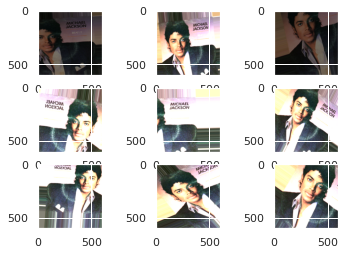

In [71]:
from tensorflow.keras.preprocessing import image
from PIL import Image

random_index = random.randint(0, len(image_paths) -1 )
img = load_img(X_train[random_index])
x = img_to_array(img)  # Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 3, 150, 150)

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.4,
        height_shift_range=0.2,
        shear_range=0.4,
        zoom_range=0.2,
        brightness_range=(0.25,2.6),
        horizontal_flip=True,
        fill_mode='nearest')

it = datagen.flow(x, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [47]:
history = model.fit(batch_generator(X_train, y_train, 128, 1), # intergrated batch generator into training
                              steps_per_epoch=10, # 300 steps with a batch size of 250 is 75,000 images per epoch
                              epochs=10, # set 10 epochs
                              validation_data = batch_generator(X_valid,y_valid, 128, 1), # integration of batch generator
                              validation_steps = 5, # number of steps for the validaiton of data
                              verbose = 1,
                              shuffle = 1) # shuffles the dataset

model.save_weights('facial_recognition_trained_weights.h5')

Epoch 1/10
10/10 [==============================] - 13s 1s/step - loss: 5.3669 - wrinkles_output_loss: 0.7878 - freakles_output_loss: 0.3261 - glasses_output_loss: 0.6969 - hair_colour_output_loss: 2.2307 - hair_top_output_loss: 1.3254 - wrinkles_output_accuracy: 0.7914 - freakles_output_accuracy: 0.9133 - glasses_output_accuracy: 0.8375 - hair_colour_output_accuracy: 0.3336 - hair_top_output_accuracy: 0.5953 - val_loss: 5.3152 - val_wrinkles_output_loss: 0.5902 - val_freakles_output_loss: 0.4609 - val_glasses_output_loss: 0.8482 - val_hair_colour_output_loss: 2.0817 - val_hair_top_output_loss: 1.3341 - val_wrinkles_output_accuracy: 0.8687 - val_freakles_output_accuracy: 0.9656 - val_glasses_output_accuracy: 0.9375 - val_hair_colour_output_accuracy: 0.2750 - val_hair_top_output_accuracy: 0.3562
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 3.5292 - wrinkles_output_loss: 0.4271 - freakles_output_loss: 0.1146 - glasses_output_loss: 0.3877 - hair_colour_output_lo

In [48]:
def history_graphs(training,validation,title):
    plt.clf()
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                        y=history.history[training],
                        name='Train'))
    fig.add_trace(go.Scatter(
                        y=history.history[validation],
                        name='Valid'))
    fig.update_layout(height=500, 
                      width=700,
                      title='Accuracy for %s feature'%title,
                      xaxis_title='Epoch',
                      yaxis_title='Accuracy')
    fig.show()

In [49]:
history_graphs('loss','val_loss','Overall loss')

<Figure size 432x288 with 0 Axes>

In [50]:
history_graphs('hair_top_output_accuracy','val_hair_top_output_accuracy','Hair Top')

<Figure size 432x288 with 0 Axes>

In [51]:
history_graphs('hair_colour_output_accuracy','val_hair_colour_output_accuracy','Hair Colour')

<Figure size 432x288 with 0 Axes>

In [52]:
history_graphs('glasses_output_accuracy','val_glasses_output_accuracy','Glasses')

<Figure size 432x288 with 0 Axes>

In [53]:
history_graphs('wrinkles_output_accuracy','val_wrinkles_output_accuracy','Wrinkles')

<Figure size 432x288 with 0 Axes>

In [54]:
history_graphs('freakles_output_accuracy','val_freakles_output_accuracy','Freakles')

<Figure size 432x288 with 0 Axes>

In [55]:
#model.load_weights('facial_recognition_trained_weights.h5')